# Analisis de Sentimientos con modelos Pre-entrenados

In [1]:
# ==========================================
# Proyecto Final: Análisis de Sentimientos
# Autor: Euly Reyes
# ==========================================
# Dependencias necesarias (instalar una vez):
# !pip install -r requirements.txt
# ==========================================

In [2]:
#Importar modulos

import kagglehub 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [3]:
# Descarga del dataset
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

#Descargas requeridas
plt.style.use('ggplot')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ereyes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ereyes\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ereyes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# leer el dataset
df = pd.read_csv(path+'\\reviews.csv')
df = df.sample(500)
df = df.reset_index(drop=True)

## Analisis Exploratorio

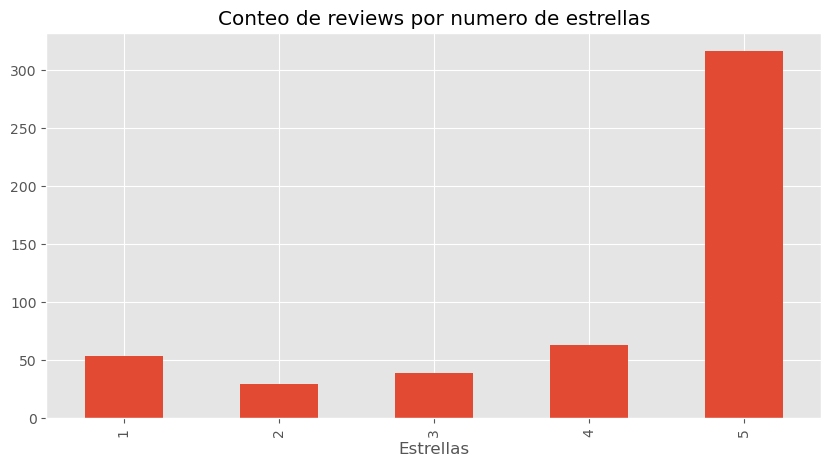

In [5]:
#Creamos un chart para contar la cantidad de reviews por estrellas
ax = df['Score'].value_counts().sort_index()\
.plot(kind='bar', 
      title='Conteo de reviews por numero de estrellas', 
      figsize=(10,5))
ax.set_xlabel('Estrellas')
plt.show(ax)

## NLTK
### libreria para el procesamiento de lenguaje natural

In [6]:
#Tomamos un ejemplo del dataset
ejemplo= df['Text'].values[3]
print(ejemplo)

10 times better than any snack mix we have tried. Kids and adults love this. My kids love it in their lunch box.


In [7]:
#Tokenizamos las palabras del ejemplo
tokens = nltk.word_tokenize(ejemplo)
#Tagueamos las palabras segun sus tipos
tokens_tageados = nltk.pos_tag(tokens)

# Vader Aproach 

### Este metodo le asigna un numero de score que puede estar entre 'Bueno', 'Malo' o 'Neutral'.

In [8]:
#Importamos el SentimentIntensityAnalyzer para asignarle valores a oraciones segun las palabras que contenga
sia = SentimentIntensityAnalyzer()

In [9]:
res = {}
#Creamos un loop para asignarle la Id como llave y de valor le asignamos la puntuacion que le da el modelo al texto
for i, row in tqdm(df.iterrows(),total= len(df)):
    Texto = row['Text']
    Id = row['Id']
    res[Id] = sia.polarity_scores(Texto)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
#Hacemos la fusion entre el dataset original y el dataset resultante del analisis
df_vaders = pd.DataFrame(res).T
df_vaders = df_vaders.reset_index().rename(columns={'index' : 'Id'})
df_vaders = df_vaders.merge(df, how='left')

## Visualizacion acerca del compound vs las estrellas

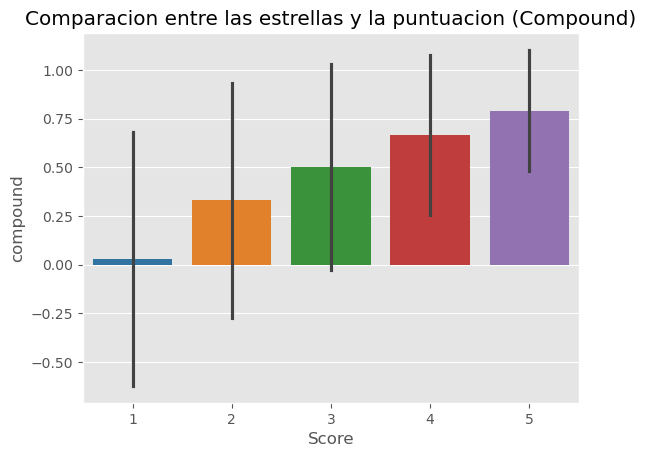

In [11]:
# Creamos un chart para comparar el numero asignado por el modelo y el numero de estrellas
ax = sns.barplot(data=df_vaders,x='Score',y='compound', palette='tab10', errorbar='sd',hue='Score',legend=False)
ax.set_xlabel("Score", fontsize = 12)
ax.set_title('Comparacion entre las estrellas y la puntuacion (Compound)')
plt.show()

#### Podemos ver que segun aumentan las estrellas el compound tambien aumenta, lo cual demuestra que segun aumentan el numero de estrellas el analisis de sentimiento va detecatando ese cambio para dar un analisis correcto

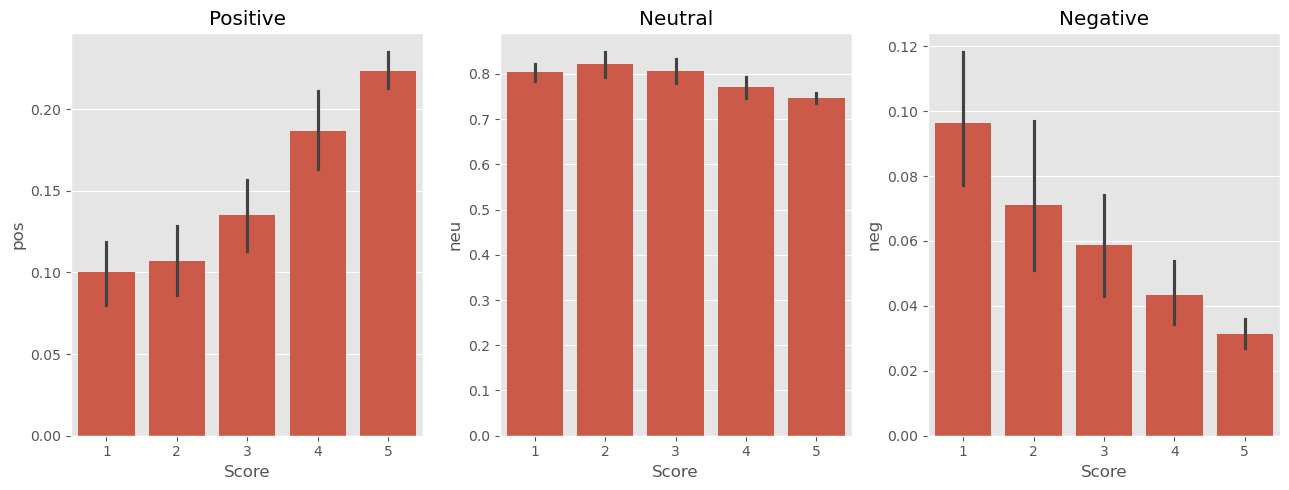

In [12]:
#Creamos un chart para visualizar los resultados del analisis
fig, axs = plt.subplots(1,3, figsize=(13,5))
sns.barplot(data=df_vaders, x='Score',y='pos', ax = axs[0]) 
sns.barplot(data=df_vaders, x='Score',y='neu', ax = axs[1])
sns.barplot(data=df_vaders, x='Score',y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

#### Podemos ver que el resultado el satisfactorio, ya que segun el numero de estrellas las predicciones son acertadas

## RoberTa Pretrained Model

#### Un modelo preentrenado no solo se basa en las palabras, sino que tambien analiza el contexto del texto

In [13]:
!pip install transformers
!pip install torch
!pip install hf_xet

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from scipy.special import softmax

In [15]:
#Definimos el modelo a utilizar
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
#Importamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL)
#Cargamos
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [16]:
print(ejemplo)
sia.polarity_scores(ejemplo)

10 times better than any snack mix we have tried. Kids and adults love this. My kids love it in their lunch box.


{'neg': 0.0, 'neu': 0.639, 'pos': 0.361, 'compound': 0.9062}

In [17]:
#Funcion para analizar los sentimientos utilizando RoberTa
def predecir_scores(ejemplo):
        encoded_ejemplo = tokenizer(ejemplo, return_tensors = 'pt') #Tokenizamos los textos
        output = model(**encoded_ejemplo) #Le pasamos el diccionario al modelo para que lo analice
        scores = output[0][0].detach().numpy() #Convertimos los tensores resultantes en numpy
        scores = softmax(scores)
    #Guardamos los resultados en un diccionario y los convertimos en flotantes
        dict_score = {
            "robert_negative": float(scores[0]),
            "robert_neutral": float(scores[1]),
            "robert_positive": float(scores[2])}
        return dict_score

### Creamos un loop para iterar el dataframe, pero utilizamos tqdm para la barra de progreso con una duracion tan larga como el df

In [27]:
for i, row in tqdm(df.iterrows(),total= len(df)):
    try:
        Texto = row['Text'] #Asignamos a nuevas variables los valores a utlizar
        Id = row['Id']
        vader_resultado = sia.polarity_scores(Texto) #Almacenamos el resultado del analisis VADER en un diccionario
        vader_result_rename = {}
        for key, value in vader_resultado.items(): #Iteramos el diccionario de resultados del modelo VADER
            vader_result_rename[f"vader_{key}"] = value #Renombramos la llave colcandole vader como prefijo y le asignamos el valor
        roberta_result = predecir_scores(Texto) #Llamamos la funcion para analizar textos con roberTa
        both = {**vader_result_rename,**roberta_result} #Unimos ambos diccionarios
        res[Id] = both #En un nuevo diccionario tomamos el ID del df original como llave y colocamos el df ya unido como valor del nuevo df
    except RuntimeError: #Manejamos la excepcion cuando el texto es muy largo
        print(f'El texto del id:{Id} es muy largo')

  0%|          | 0/500 [00:00<?, ?it/s]

El texto del id:379222 es muy largo
El texto del id:428668 es muy largo
El texto del id:248455 es muy largo
El texto del id:522197 es muy largo
El texto del id:452055 es muy largo
El texto del id:429243 es muy largo


In [28]:
df_results = pd.DataFrame(res).T #Transponemos el df
df_results = df_results.reset_index().rename(columns={'index' : 'Id'}) #Reseteamos el inidice de df para que coincidan los indices en ambos df
df_results = df_results.merge(df, how='left') #Hacemos el mergue de los dos df

In [29]:
df_results.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,robert_negative,robert_neutral,robert_positive,neg,neu,...,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,70706,0.000,0.828,0.172,0.8537,0.002402,0.013605,0.983993,NaN,NaN,...,NaN,B000NY6PY8,AXOFJA6PX4W8R,"Heather's Attic ""Heather""",0,0,5,1243468800,Addicted,I first tried these in Germany. While I was t...
1,146400,0.115,0.795,0.090,-0.4818,0.095952,0.190704,0.713345,NaN,NaN,...,NaN,B002207M20,A3BGO7U46LWLUR,Kristen,1,1,5,1337385600,Could not live without this tea!,I literally could not live without the Monthly...
2,275752,0.000,0.837,0.163,0.9781,0.001421,0.014826,0.983753,NaN,NaN,...,NaN,B000TO7U64,A3QTKI7V426P2K,Barbarams,0,0,5,1315267200,Fantastic and versatile!,I have been using Walden Farms products since ...
3,158320,0.000,0.639,0.361,0.9062,0.001656,0.007677,0.990667,NaN,NaN,...,NaN,B002QTWU4W,A263ZEDYD50VAT,sbmiller,0,0,5,1327968000,YUMMY!!,10 times better than any snack mix we have tri...
4,79293,0.023,0.783,0.194,0.9230,0.010137,0.042375,0.947488,NaN,NaN,...,NaN,B003TNANSO,AI066ESWAN83K,podushka,0,0,4,1350086400,Love the taste,"I got the dark chocolate cherry cashew, and I ..."


In [30]:
df_results = df_results.drop(columns=['neg'])
df_results = df_results.drop(columns=['neu'])
df_results = df_results.drop(columns=['pos'])
df_results = df_results.drop(columns=['compound'])

## Compare results - Roberta vs Vader

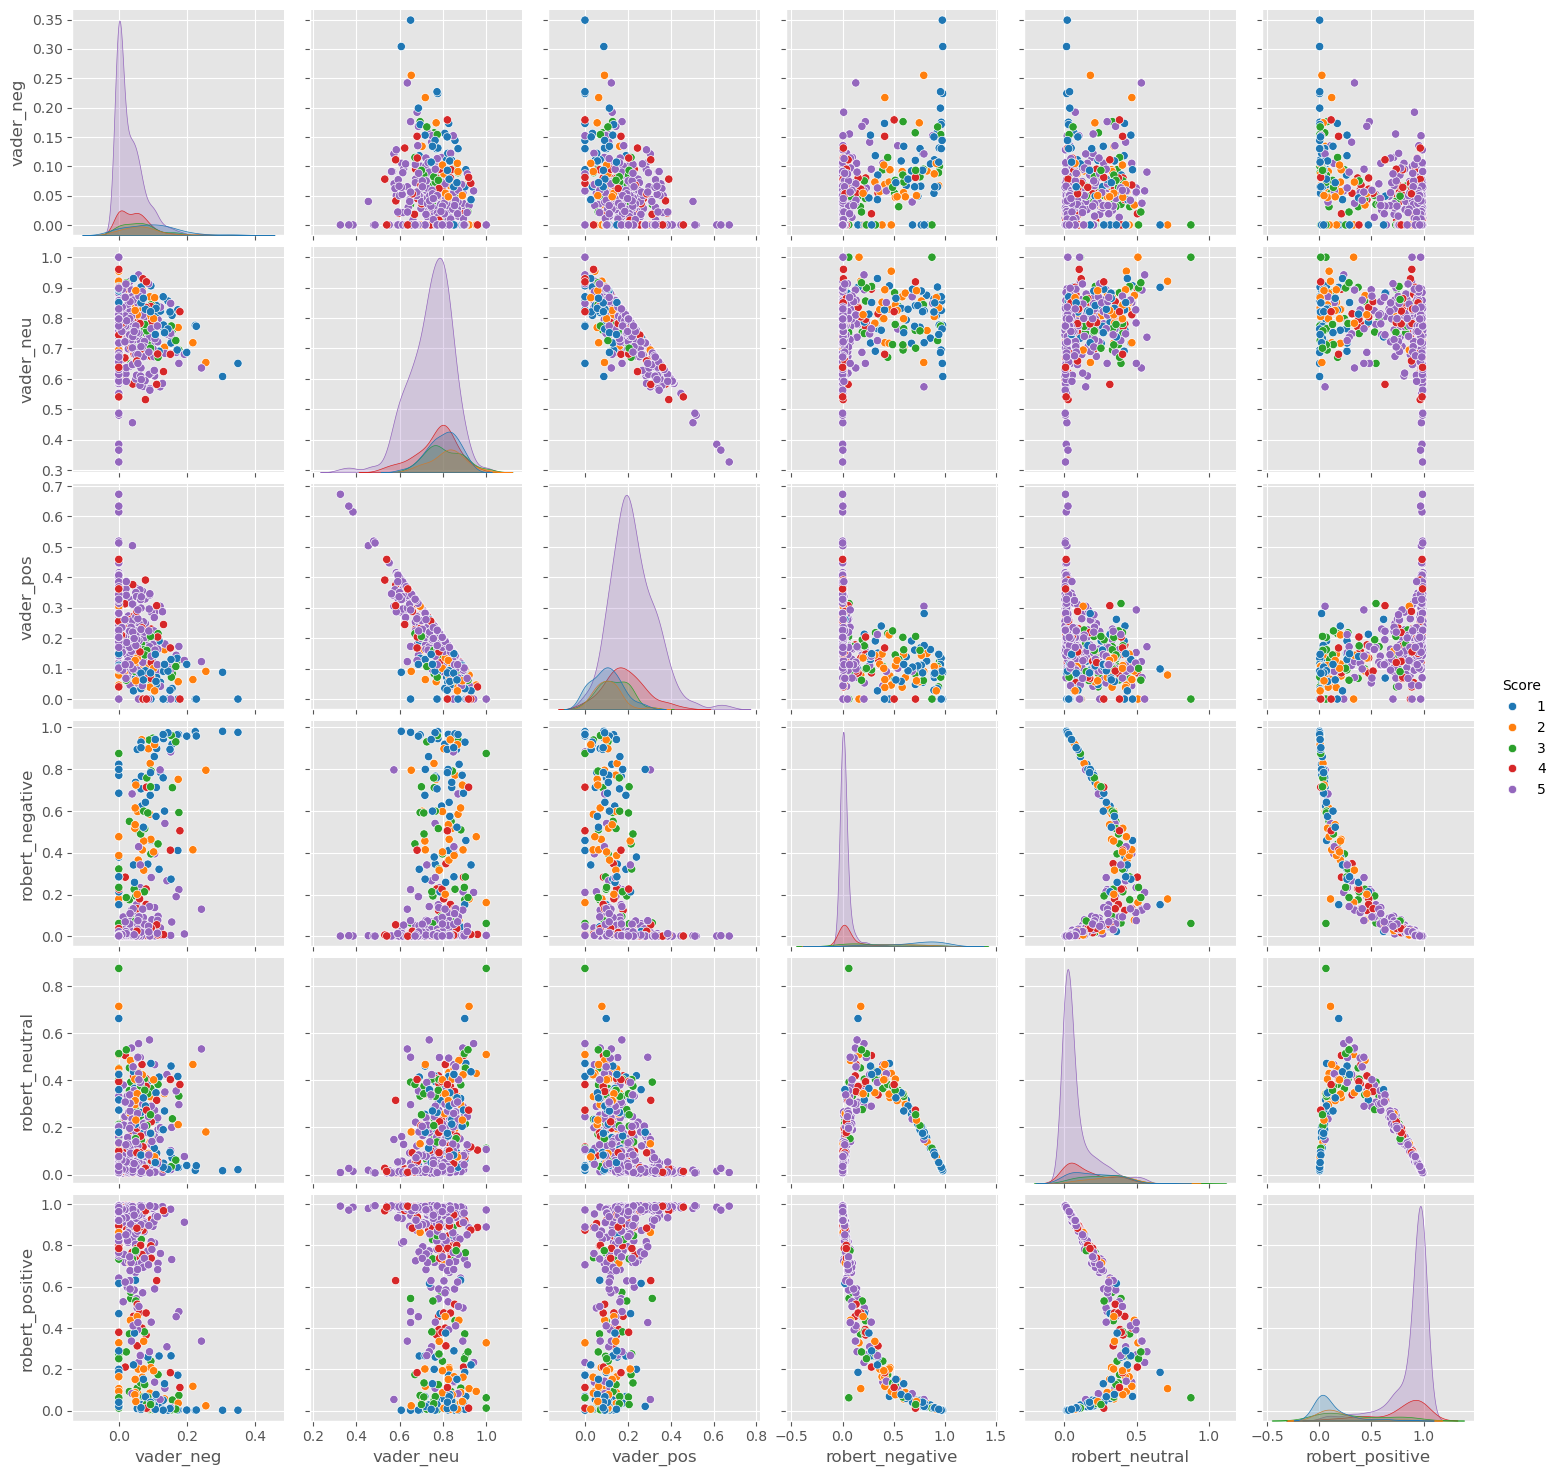

In [31]:
sns.pairplot(data=df_results, vars=[
    'vader_neg', 'vader_neu', 'vader_pos',
    'robert_negative', 'robert_neutral', 'robert_positive'
], hue='Score', palette = 'tab10')
plt.show()

#### Podemos ver que el modelo de roberTa posee mas 'Seguridad' al momento de hacer la predicción en cambio el Vader se encuentra mas 'indeciso'.

## Malinterpretacion de los modelos

### Aqui podemos ver que los modelos le colocan una clasificación positiva aun cuando el Score es de una estrella.

In [32]:
df_results.query("Score == 1").sort_values('robert_positive', ascending=False)['Text'].values[0]

'The reason why I buy the Starbucks brand is because their coffee has a special signature taste. This Blonde line they offer taste more like a dollar bag of coffee you would get form Dollar tree.'

In [33]:
df_results.query("Score == 1").sort_values('vader_pos', ascending=False)['Text'].values[0]

'I found this in the natural category. Trust me it is not natural! Splenda is as toxic a sweetener as aspartame (NutraSweet/Equal). Check out the site Splendaexposed(dot)com.'

## Casos en los que el modelo lo clasifica como negativos aun cuando cuentan con 5 estrellas de Score

In [34]:
df_results.query("Score == 5").sort_values('robert_negative', ascending=False)['Text'].values[2]

"After reading the reviews I absolutely had to write one myself. The product is awsome convenient and reasonably priced being you get 3 servings of fruit in one bag.<br /><br />The reason I had to write the review is due to the arrogance of the people rating this product below a 3 star rating IF YOU DON'T KNOW WHAT FREEZ-DRIED MEANS, DON'T WRITE A BAD REVIEW, DO YOUR OWN RESEARCH. You all sound like idiots, if you buy a Lamborghini you can't complain it goes too fast."

In [35]:
df_results.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

"It's hard to find good smokehouse bacon.  This one fits the bill.  Cook over low heat to avoid burning."